In [71]:
#Mount data source
from google.colab import drive
import os

In [72]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
pwd

'/content'

In [4]:
os.chdir('drive/MyDrive/Log')

In [73]:
ls

 3_2_ANSYS0.docx
'AM - 03 18 2021.gdoc'
 AM_ML_.ipynb
 amProcess.ipynb
 autoMLAM.ipynb
 blcokSPS.docx
'Copy of SPS0.pdf'
 data0.xlsx
 data1.xlsx
 data2.xlsx
 data3.xlsx
 data.xlsx
 GP.docx
 heat.png
 investigation_draft.docx
'Jet Engine Work.gdoc'
 jouleHeat.gdoc
'Joule heating initial model approach.gslides'
'Joule heating - Wikipedia.gdoc'
 jouleModel.gdraw
 matlab_import.csv
'MATLAB Modeling and FEM Simulation of Heat Induced Stress'
'Model Evaluation.docx'
 ptest.m
'Ramp Thin Wall Images.pptx'
 Solidification.gdoc
 spot.tif
 spsINL.pptx
 spsModel0.m
 spsModelSim.slx
 spsModelSim.slxc
 spsPID.gdoc
'SPS Research question.gdoc'
'SPS status.gdoc'
 state_dic_model.pt
 StatusSPS.docx
 timelineSPS.xlsx
 tpot_insurance_best_model.py


In [74]:
#Read data and pre-process

In [75]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np

In [76]:
dataAnalysis=pd.read_excel('data2.xlsx', usecols=[0,1,2])

In [77]:
# Configuration
PFR=12 #RPM
Z_off = 7.94 #mm
traverse_speed=20 #ipm
expected_dT= 0.01
camera=100 #fps
layers=50;
# Geometry : Wall
length_layer=2 #inch
dpl=(length_layer/(traverse_speed/60))/expected_dT#~data points per layer #################


t0=dataAnalysis['Time'][0]
meanT=0.0
count=0
for t in dataAnalysis['Time'][1:]:
  if t-t0 < expected_dT*2:
    meanT=meanT+(t-t0)
    count=count+1
  t0=t
meanT=meanT/count
dpl=(length_layer/(traverse_speed/60))/meanT ##############################################
print('count: {%d}' % count)
print('Mean Period: {%f}' % meanT)
print('Data points per layer estimate: ~%d' % dpl)

count: {30244}
Mean Period: {0.010000}
Data points per layer estimate: ~599


In [78]:
dpl=round(dataAnalysis.shape[0]/layers)#########################################
print('Data points per layer estimate: ~%d' % dpl)

Data points per layer estimate: ~605


In [79]:
data=pd.read_excel('data2.xlsx', usecols=[1,2]) #Removed head zeros and tail zeros

In [80]:
#dataAnalysis.head()
dataAnalysis.tail()

,Time,Laser Power,Diameter
30246,160106.616,2.62732,1.000000
30247,160106.626,2.62732,1.000000
30248,160106.636,2.62732,1.021739
30249,160106.646,2.62732,1.021739
30250,160106.656,2.62732,0.391304


In [81]:
data['x']=np.nan #2
data['y']=np.nan #3
count=0
layer=0
for i in range(0,data.shape[0]):
  data.iloc[i,2]=count
  data.iloc[i,3]=layer
  count=count+1
  if count%dpl==0:
    count=0
    layer=layer+1

In [82]:
trim_percent=5
trim_points_side=round(dpl*trim_percent/200)
print('Trim point from each side of layer: %d' % trim_points_side)

Trim point from each side of layer: 15


In [83]:
temp=[]
for i in range(0,data.shape[0]):
  if data.iloc[i,2] < trim_points_side or data.iloc[i,2] >= (dpl-trim_points_side):
    temp.append(i)

data.drop(data.index[temp], inplace=True)

In [84]:
data

,Laser Power,Diameter,x,y
15,2.493555,0.695652,15.0,0.0
16,2.493555,0.695652,16.0,0.0
17,2.493555,0.673913,17.0,0.0
18,2.493555,0.717391,18.0,0.0
19,2.493555,0.717391,19.0,0.0
...,...,...,...,...
30230,2.606741,0.934783,585.0,49.0
30231,2.606741,0.934783,586.0,49.0
30232,2.606741,0.934783,587.0,49.0
30233,2.606741,0.891304,588.0,49.0


In [85]:
data.describe()

,Laser Power,Diameter,x,y
count,28750.000000,28750.000000,28750.000000,28750.000000
mean,3.252621,0.951753,302.000000,24.500000
std,0.446205,0.167456,165.990838,14.431121
min,2.478121,0.000000,15.000000,0.000000
25%,2.833112,0.913043,158.000000,12.000000
50%,3.249841,0.956522,302.000000,24.500000
75%,3.661424,1.021739,446.000000,37.000000
max,4.031850,2.152174,589.000000,49.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f12ea666650>,
      dtype=object)

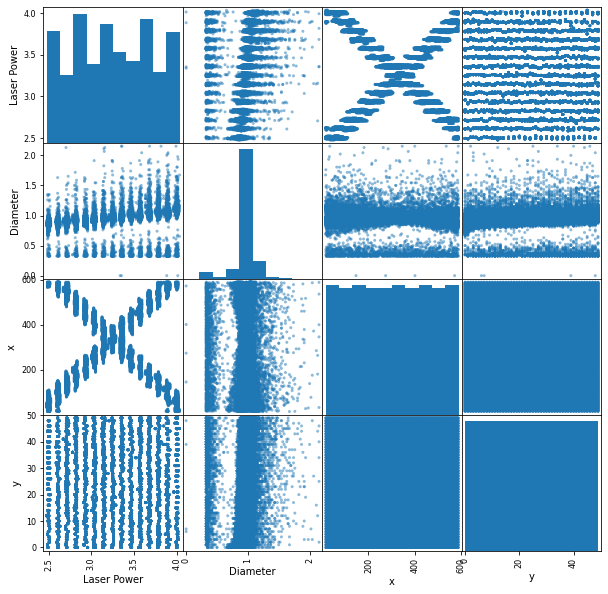

In [86]:
pd.plotting.scatter_matrix(data, figsize=(10,10))

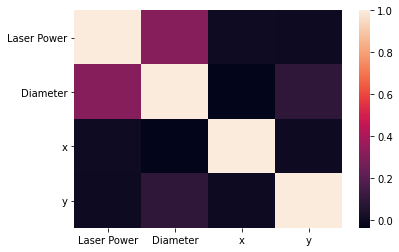

In [87]:
sn.heatmap(data.corr())
plt.show()

In [88]:
def reform(data, pastpos=1, inCol=0, outCol=1, x=2, y=3):
  temp=pd.DataFrame()

  temp['inCol'+str(0)]=data.iloc[:,inCol]
  for i in range(pastpos):
    temp['inCol'+str(i+1)]=np.nan
    temp['inCol'+str(i+1)][i+1:]=data.iloc[:-i-1,inCol]

  for i in range(pastpos):
    temp['outCol'+str(i+1)]=np.nan
    temp['outCol'+str(i+1)][i+1:]=data.iloc[:-i-1,outCol]
  temp['x0']=data.iloc[:,x]
  temp['y0']=data.iloc[:,y]
  temp['Out']=data.iloc[:,outCol]
  return temp.iloc[pastpos:,:]

pastpos=1 

In [89]:
dataFrame=reform(data)

In [90]:
dataFrame

,inCol0,inCol1,outCol1,x0,y0,Out
16,2.493555,2.493555,0.695652,16.0,0.0,0.695652
17,2.493555,2.493555,0.695652,17.0,0.0,0.673913
18,2.493555,2.493555,0.673913,18.0,0.0,0.717391
19,2.493555,2.493555,0.717391,19.0,0.0,0.717391
20,2.493555,2.493555,0.717391,20.0,0.0,0.717391
...,...,...,...,...,...,...
30230,2.606741,2.606741,0.978261,585.0,49.0,0.934783
30231,2.606741,2.606741,0.934783,586.0,49.0,0.934783
30232,2.606741,2.606741,0.934783,587.0,49.0,0.934783
30233,2.606741,2.606741,0.934783,588.0,49.0,0.891304


In [91]:
#Only if you want to export new dataset!
dataFrame.to_csv('matlab_import.csv', index=False, index_label=False)

In [31]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
from torch.autograd import Variable

In [32]:
print(torch.__version__)

1.9.0+cu102


In [33]:
x=dataFrame.values[:,:-1].astype('float32')
y=dataFrame.values[:,-1].astype('float32')
y=y.reshape(len(y),1)
scale=MinMaxScaler(feature_range=(0,1))

In [34]:
x=scale.fit_transform(x)
y=scale.fit_transform(y)

In [35]:
y

array([[0.32323223],
       [0.3131313 ],
       [0.3333332 ],
       ...,
       [0.4343436 ],
       [0.41414127],
       [0.4242422 ]], dtype=float32)

In [36]:
x.shape

(28749, 5)

In [ ]:
#x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.33, random_state=42)

In [93]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

Epoch 1/100
719/719 [==============================] - 1s 1ms/step - loss: 0.0995
Epoch 2/100
719/719 [==============================] - 1s 1ms/step - loss: 0.0290
Epoch 3/100
719/719 [==============================] - 1s 1ms/step - loss: 0.0285
Epoch 4/100
719/719 [==============================] - 1s 1ms/step - loss: 0.0279
Epoch 5/100
719/719 [==============================] - 1s 1ms/step - loss: 0.0261
Epoch 6/100
719/719 [==============================] - 1s 1ms/step - loss: 0.0254
Epoch 7/100
719/719 [==============================] - 1s 1ms/step - loss: 0.0259
Epoch 8/100
719/719 [==============================] - 1s 1ms/step - loss: 0.0258
Epoch 9/100
719/719 [==============================] - 1s 1ms/step - loss: 0.0251
Epoch 10/100
719/719 [==============================] - 1s 1ms/step - loss: 0.0251
Epoch 11/100
719/719 [==============================] - 1s 1ms/step - loss: 0.0245
Epoch 12/100
719/719 [==============================] - 1s 1ms/step - loss: 0.0243
Epoch 13/100


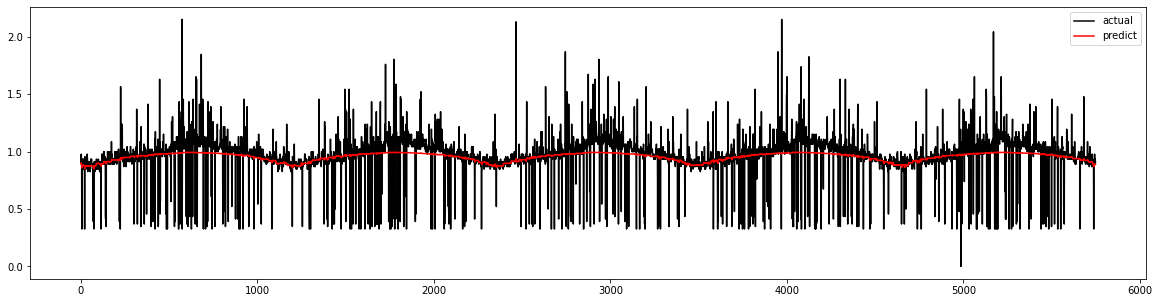

In [94]:
# Restart the whole thing if you are running everything else without keras
# Keras version
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

# load the dataset
dataset_keras = loadtxt('matlab_import.csv', delimiter=',',skiprows=1)
train_percent=0.8
train_index=round(dataset_keras.shape[0]*train_percent)
# split into input (x) and output (y) variables
x_train_keras = dataset_keras[:train_index,0:5] # This may change depending on data
y_train_keras = dataset_keras[:train_index,5] # This may change depending on data
x_test_keras = dataset_keras[train_index:,0:5] # This may change depending on data
y_test_keras = dataset_keras[train_index:,5] # This may change depending on data
# define the keras model
model_keras = Sequential()
model_keras.add(Dense(10, input_dim=5, activation='relu', kernel_initializer='normal'))
model_keras.add(Dense(10, activation='relu',kernel_initializer='normal'))
model_keras.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))
# compile the keras model
model_keras.compile(loss='mean_squared_error', optimizer='adam')
# fit the keras model on the dataset
model_keras.fit(x_train_keras, y_train_keras, epochs=100, batch_size=32)

# evaluate the keras model
y_test_predict = model_keras.predict(x_test_keras)
plt.figure(figsize=(20,5))
plt.plot(y_test_keras,'k',label='actual')
plt.plot(y_test_predict,'r',label='predict')
plt.legend()
plt.show()

In [95]:
model_keras.save("matlab_h5_model.h5")

In [ ]:
class dataform(torch.utils.data.Dataset):
    # load the dataset
    def __init__(self,x,y):
        # store the inputs and outputs
        self.X = x
        self.y = y
 
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    # get indexes for train and test rows
    def get_splits(self, n_test=0.33): #################################################
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return torch.utils.data.random_split(self, [train_size, test_size])

In [ ]:
#Develop DNN for regression

In [ ]:
class MLP(torch.nn.Module):
  def __init__(self, n_features, n_hidden):
    super(MLP, self).__init__()

    self.hidden1 = torch.nn.Linear(n_features, n_hidden)
    #No weight initialization
    self.activation1=torch.nn.Sigmoid()
    #torch.nn.functional.sigmoid(x) -- we can use this too!
    self.hidden2 = torch.nn.Linear(n_hidden, n_hidden)
    #No weight initialization
    self.activation2=torch.nn.Sigmoid()
    self.predict = torch.nn.Linear(n_hidden, 1)
    #No weight initialization

    self.bn1=torch.nn.BatchNorm1d(num_features=n_hidden)
    self.bn2=torch.nn.BatchNorm1d(num_features=n_hidden)

  def forward(self, x):
    x=self.hidden1(x)
    x=self.bn1(x)
    x=self.activation1(x)
    x=self.hidden2(x)
    x=self.bn2(x)
    x=self.activation2(x)
    x=self.predict(x)

    return x    



In [ ]:
features=2*pastpos+3 #LP & Diameter past + current laser + (x,y)
model=MLP(features,10)
criterion=torch.nn.MSELoss()
optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
print(model)

MLP(
  (hidden1): Linear(in_features=5, out_features=10, bias=True)
  (activation1): Sigmoid()
  (hidden2): Linear(in_features=10, out_features=10, bias=True)
  (activation2): Sigmoid()
  (predict): Linear(in_features=10, out_features=1, bias=True)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
torch.save(model.state_dict(), 'state_dic_model.pt')

In [ ]:
# prepare the dataset
def prepare_data():
    # load the dataset
    dataset = dataform(x,y)
    # calculate split
    train, test = dataset.get_splits()
    # prepare data loaders
    train_dl = torch.utils.data.DataLoader(train, batch_size=32, shuffle=False)#############################################
    test_dl = torch.utils.data.DataLoader(test, batch_size=1024, shuffle=False)
    return train_dl, test_dl

In [ ]:
train_dl, test_dl = prepare_data()
print(len(train_dl.dataset), len(test_dl.dataset))

19262 9487


In [ ]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader


def train_val_dataset(datasetT, val_split=0.33):
    train_idx, val_idx = train_test_split(list(range(len(datasetT))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(datasetT, train_idx)
    datasets['val'] = Subset(datasetT, val_idx)
    return datasets

dataset = dataform(x,y)

print(len(dataset))
datasets = train_val_dataset(dataset)
print(len(datasets['train']))
print(len(datasets['val']))
# The original dataset is available in the Subset class
print(datasets['train'].dataset)
train=datasets['train']
test=datasets['val']

train_dl = DataLoader(train, batch_size=32, shuffle=False)#############################################
test_dl = DataLoader(test, batch_size=1024, shuffle=False)

28749
19261
9488


In [ ]:
print(len(train_dl.dataset), len(test_dl.dataset))

19261 9488


In [ ]:
for epoch in range(100):
  # enumerate mini batches
  for i, (inputs, targets) in enumerate(train_dl):
    # clear the gradients
    optimizer.zero_grad()
    # compute the model output
    yhat = model(inputs)
    # calculate loss
    loss = criterion(yhat, targets)
    # credit assignment
    loss.backward()
    # update model weights
    optimizer.step()
  print("\r", "Epoch: {}".format(epoch), end="")

 Epoch: 99

In [ ]:
#scale.inverse_transform(array)

In [ ]:
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        #print(targets)
        #print(targets.shape)
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
        #break
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate mse
    mse = mean_squared_error(actuals, predictions)
    return mse, actuals, predictions

In [ ]:
mse, actuals, predictions = evaluate_model(test_dl, model)
print('MSE: %.3f, RMSE: %.3f' % (mse, np.sqrt(mse)))

MSE: 0.002, RMSE: 0.049


In [ ]:
#Percent fit : MATLAB SID
(1-(np.sqrt(sum((actuals-predictions)**2))/np.sqrt(sum((actuals-actuals.mean())**2))))*100

array([35.409714], dtype=float32)

In [ ]:
x=torch.tensor(x)
y=torch.tensor(y)

In [ ]:
y_predict=model(x)

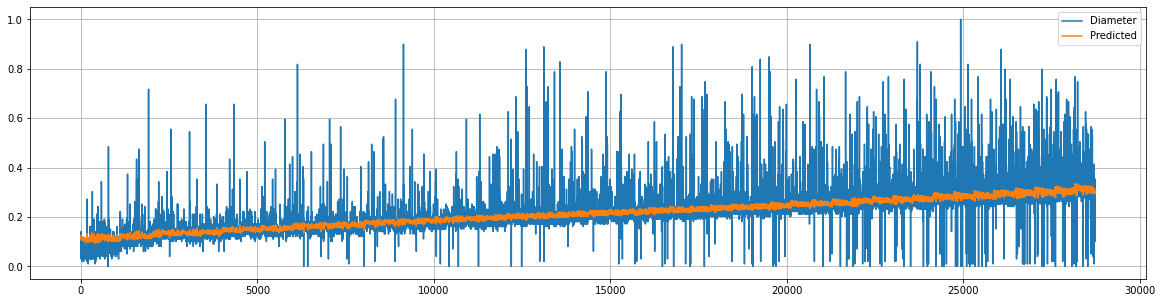

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(y.detach().numpy()[0:-1], label='Diameter')
plt.plot(y_predict.detach().numpy()[0:-1], label='Predicted')
plt.legend()
plt.grid()
plt.show()

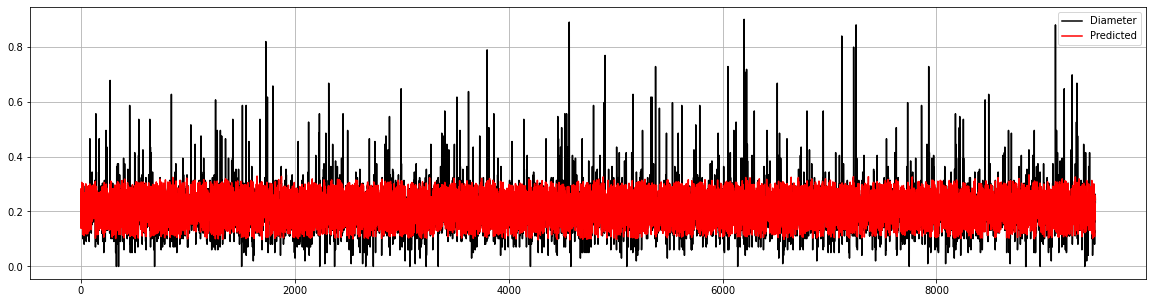

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(actuals[0:-1], 'k',label='Diameter')
plt.plot(predictions[0:-1], 'r',label='Predicted')
plt.legend()
plt.grid()
plt.show()

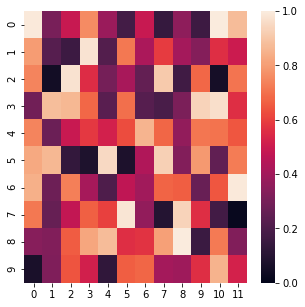

In [ ]:
import seaborn as sn
uniform_data = np.random.rand(10, 12)
plt.figure(figsize=(5,5))
ax=sn.heatmap(uniform_data, vmin=0, vmax=1)
fig=plt.gcf()

In [ ]:
fig.savefig('heat.png', dpi=100)

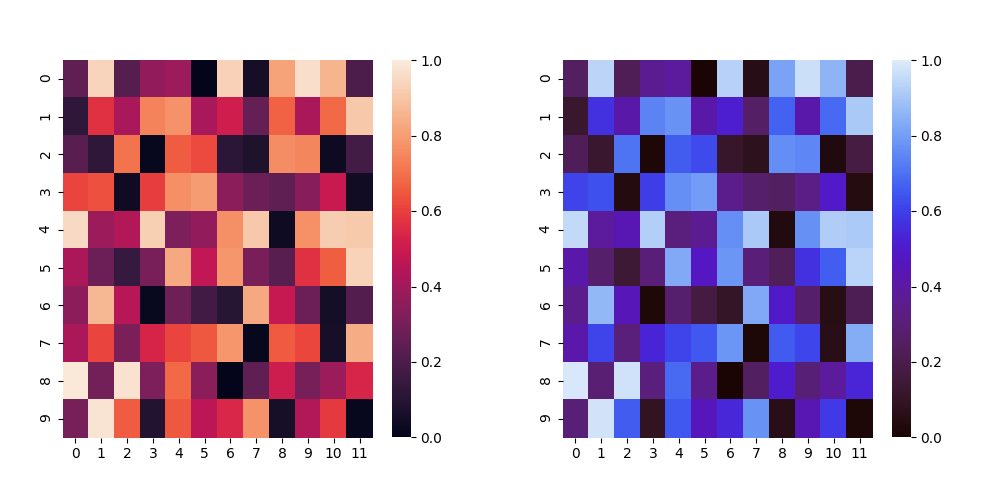

-1

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from skimage import io
img = cv2.imread("heat.png")
img2= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = img[0:100, 0:100]
cv2_imshow(cv2.hconcat([img,img2]))
#cv2_imshow(img2)
cv2.waitKey(0)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42, shuffle=False)

In [ ]:
pip install tpot

     |████████████████████████████████| 92kB 4.1MB/s 
     |████████████████████████████████| 166.7MB 80kB/s 
     |████████████████████████████████| 163kB 41.5MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp37-none-any.whl size=11954 sha256=a2ed4f7ec960c52b06c80ac831c8adf9eeeb49ee879e1fd0d33b6bf11c86cdab
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
import tpot
tpot.__version__

'0.11.7'

In [ ]:
from sklearn.model_selection import RepeatedKFold
from tpot import TPOTRegressor

In [ ]:
# define evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search
model = TPOTRegressor(generations=5, population_size=50, scoring='neg_mean_absolute_error', cv=cv, verbosity=2, random_state=1, n_jobs=-1)
# perform the search
model.fit(x_train, y_train)
# export the best model
#model.export('tpot_insurance_best_model.py')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Generation 1 - Current best internal CV score: -0.01630576420038405

Generation 2 - Current best internal CV score: -0.01630576420038405

Generation 3 - Current best internal CV score: -0.0162911136661319

Generation 4 - Current best internal CV score: -0.0162911136661319

Generation 5 - Current best internal CV score: -0.016290470263583035

Best pipeline: GradientBoostingRegressor(ZeroCount(input_matrix), alpha=0.75, learning_rate=0.1, loss=lad, max_depth=5, max_features=0.8500000000000001, min_samples_leaf=16, min_samples_split=19, n_estimators=100, subsample=0.7500000000000001)


TPOTRegressor(config_dict=None, crossover_rate=0.1,
              cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
              disable_update_check=False, early_stop=None, generations=5,
              log_file=None, max_eval_time_mins=5, max_time_mins=None,
              memory=None, mutation_rate=0.9, n_jobs=-1, offspring_size=None,
              periodic_checkpoint_folder=None, population_size=50,
              random_state=1, scoring='neg_mean_absolute_error', subsample=1.0,
              template=None, use_dask=False, verbosity=2, warm_start=False)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
#tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
#features = tpot_data.drop('target', axis=1)
#training_features, testing_features, training_target, testing_target = \
#            train_test_split(features, tpot_data['target'], random_state=1)

# Average CV score on the training set was: -0.023423252693942343
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=RidgeCV()),
    GradientBoostingRegressor(alpha=0.75, learning_rate=0.1, loss="lad", max_depth=5, max_features=0.85, min_samples_leaf=16, min_samples_split=19, n_estimators=100, subsample=0.7500000000000001)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 1)

exported_pipeline.fit(x_train, y_train)
results = exported_pipeline.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


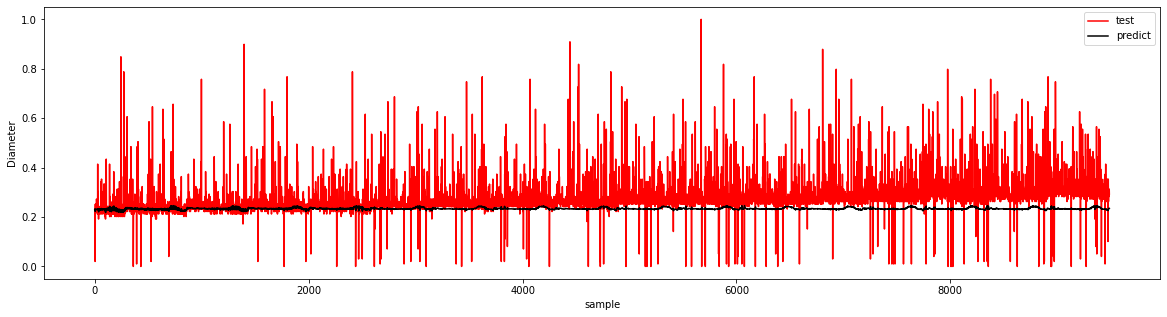

In [ ]:
plt.figure(figsize=(20,5))
plt.xlabel('sample')
plt.ylabel('Diameter')
plt.plot(y_test, 'r', label='test')
plt.plot(results, 'k', label='predict')
plt.legend()
plt.show()

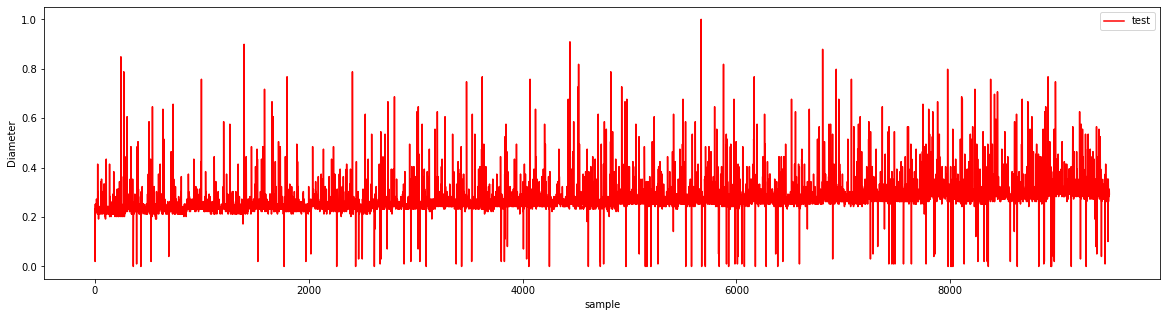

In [ ]:
plt.figure(figsize=(20,5))
plt.xlabel('sample')
plt.ylabel('Diameter')
plt.plot(y_test, 'r', label='test')
plt.legend()
plt.show()

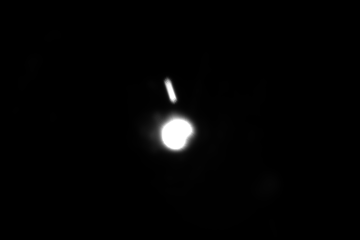

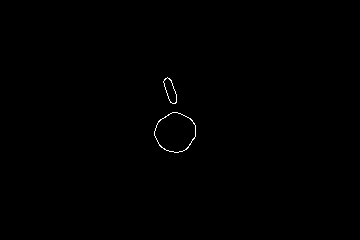

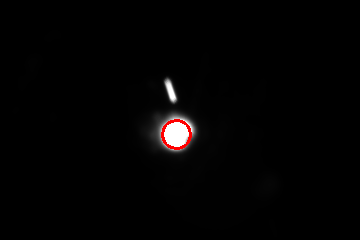

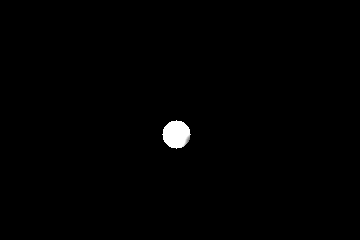

In [ ]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
img = cv2.imread('spot.tif')

scale_percent = 50 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

img = cv2.medianBlur(img,5)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cimg=cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
ret, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
edges = cv2.Canny(thresh, 100, 200)

circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1 = 50, param2 = 30, minRadius = 10, maxRadius = 25)
circles=np.uint16(np.around(circles))

xc=0
yc=0
r=0

for i in circles[0,:]:
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,0,255),2) #cv2.circle(source, center(x,y), radius, color, linetype)
    xc=i[0]
    yc=i[1]
    r=i[2]

mask = np.zeros_like(img)
mask = cv2.circle(mask, (xc,yc), r, (255,255,255), -1) # -1 fills the interior
result = cv2.bitwise_and(img, mask)

cv2_imshow(img)
cv2_imshow(edges)
cv2_imshow(cimg)
cv2_imshow(result)

cv2.waitKey(0)
cv2.destroyAllWindows()

#cv2.imwrite('jeep_mask.png', mask)